In [ ]:
!pip install pythainlp


In [ ]:
!pip install gensim

In [ ]:
import tensorflow as tf
Model = tf.keras.models.Model
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_model = tf.keras.models.load_model

import pandas as pd
import re
from pythainlp.tokenize import word_tokenize, Tokenizer
KRTokenizer = tf.keras.preprocessing.text.Tokenizer

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint

# from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import string
# from os import listdir
from string import punctuation
# from os import listdir

#########################
from pythainlp.tokenize import word_tokenize #, Tokenizer
from pythainlp.corpus.common import thai_words

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from pythainlp.corpus import thai_stopwords

from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
EPOCHS = 300
BS = 32
DIMENSION = 256

In [ ]:
# import aiohttp
# import asyncio

# API_SENTIMENT_URL = "https://api.aiforthai.in.th/ssense"
# API_BULLY_URL = "https://api.aiforthai.in.th/bully"
# API_KEY = "MLmi4VDme8ONK91lcqSUkc90vqqK7TgU"

# RETRY_DELAY = 3
# MAX_RETRIES = 10

# async def analyze_sentiment(session, comment):
#     """วิเคราะห์ sentiment (pos, neu, neg)"""
#     headers = {"Apikey": API_KEY}
#     params = {"text": comment}

#     for _ in range(MAX_RETRIES):
#         try:
#             async with session.get(API_SENTIMENT_URL, headers=headers, params=params) as response:
#                 if response.status == 200:
#                     result = await response.json()
#                     sentiment = result.get("sentiment", {}).get("polarity", "neutral")
#                     return sentiment[:3] if sentiment in ["positive", "negative", "neutral"] else "neu"
#         except Exception as e:
#             print(f"❌ Error in sentiment API: {e}")
#         await asyncio.sleep(RETRY_DELAY)

#     return "neu"

# async def analyze_bully(session, comment):
#     """ตรวจสอบคำหยาบและบูลลี่"""
#     headers = {"Apikey": API_KEY}
#     params = {"text": comment}

#     for _ in range(MAX_RETRIES):
#         try:
#             async with session.get(API_BULLY_URL, headers=headers, params=params) as response:
#                 if response.status == 200:
#                     result = await response.json()
#                     bully_type = result.get("bully_type", [])

#                     if not bully_type or 0 in bully_type:
#                         return "neg"

#                     if any(bt in [2, 6] for bt in bully_type):  # คำหยาบ, ข่มขู่
#                         return "hig"

#                     if any(bt in [1, 3, 4, 5] for bt in bully_type):  # บูลลี่
#                         return "bly"

#         except Exception as e:
#             print(f"❌ Error in bully API: {e}")
#         await asyncio.sleep(RETRY_DELAY)

#     return "neg"

# async def analyze_comment(session, comment):
#     """รวมการวิเคราะห์ sentiment และคำหยาบ"""
#     sentiment = await analyze_sentiment(session, comment)

#     if sentiment == "neg":
#         return await analyze_bully(session, comment)
#     return sentiment

# async def process_comments():
#     """อ่านไฟล์ train.txt และวิเคราะห์ข้อความ"""
#     label_counts = {"pos": 0, "neu": 0, "neg": 0, "hig": 0, "bly": 0}

#     with open("train.txt", "r", encoding="utf-8") as file:
#         comments = [line.strip() for line in file if line.strip()]

#     async with aiohttp.ClientSession() as session:
#         tasks = [analyze_comment(session, comment) for comment in comments]
#         results = await asyncio.gather(*tasks)

#     with open("train_label.txt", "w", encoding="utf-8") as file:
#         for result in results:
#             file.write(f"{result}\n")
#             if result in label_counts:
#                 label_counts[result] += 1

#     print(f"✅ วิเคราะห์เสร็จแล้ว! ผลลัพธ์บันทึกที่ train_label.txt")
#     for label, count in label_counts.items():
#         print(f"จำนวน {label}: {count} คำ")

# # รันโปรแกรม
# await process_comments()


In [ ]:
comments = []
labels = []

with open("train_cleaned.txt",encoding="utf-8") as f:
    for line in f:
        comments.append(line.strip())

with open("train_label (3).txt",encoding="utf-8") as f:
    for line in f:
        labels.append(line.strip())

In [ ]:
print(len(comments), len(labels))


63456 63456


In [ ]:
df = pd.DataFrame({ "category": labels, "comments": comments })
df.head()

,category,comments
0,pos,ถ้าครั้งนี้มันจะเป็นบทเรียน ก็จะดีมากถ้านายห้า...
1,neu,พี่หนุ่มคือที่สุด
2,neu,แก๊ป แสตมป์ บอส ลำใย และอีกหลายๆ
3,pos,ใหทองคำเคยผ่านมรสุมมาแล้วแต่ก็แกร็งและยังยืนอย...
4,neg,นายฮ่างทำถูกแล้วละทะเลาะกับเด็กไปตัวเองก็มีแต่...


In [ ]:
df = df.drop_duplicates()

In [ ]:
neu_df = df[df.category == "neu"].sample(1300)
neu_df.head()

,category,comments
51905,neu,พี่ซ่าร่าเจอมิจจริงๆ
50508,neu,อยากรู้เรื่องท้ายรายการ คืออ่ะไร
22075,neu,ปุ้ยคงจะ มาก
20581,neu,บ้ายบาย
53757,neu,เยอะมากขอบคุณซาร่ามากที่มาเเฉเงินมหาศาลมากที่ถ...


In [ ]:
bly_df = df[df.category == "bly"].sample(1300)
bly_df.head()

,category,comments
29917,bly,หมาแล้ว ไม่ใช่คนแบบนี้ เลวยิ่งกว่าเดรัจฉาน อีแ...
38557,bly,อี ดร ไม่มีมารยาท สันดานแบบนี้ เหมาะสมกับ พ่อม...
30590,bly,ป่วยจิตป่าว
51300,bly,ดูจากคลิป และการพูดในวันนี้ เชื่อถือคุณภรรยาค่...
17873,bly,คนคบกันก็มีโอกาสเลิกกันหละ แต่ก็ควรจะเลิกกันให...


In [ ]:
hig_df = df[df.category == "hig"].sample(1300)
hig_df.head()

,category,comments
27408,hig,เขายังเป็นเด็กคุณทำไมไม่พูดดีๆทำไมต้องตีขนาดนี...
10423,hig,เป็น ผช ที่เชื่อทุกอย่างในโลกโซเชียว โดนปั่นหั...
59894,hig,ฝ้าพังตามอายุของบ้าน ไอครูมึงคิดว่าบ้านมันจะพั...
35097,hig,แกตบขนาดนี้เลยอ่ะถ้าเป็นญาตชั้นนะมึงโดนแน่
57029,hig,จับเข้าคุกให้หมดพวกไม่ทำมาหาแดกไปหลวงลวงชาวบ้าน


In [ ]:
pos_df = df[df.category == "pos"].sample(1300)
pos_df.head()

,category,comments
887,pos,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...
29707,pos,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...
20345,pos,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...
34399,pos,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...
54724,pos,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...


In [ ]:
neg_df = df[df.category == "neg"].sample(1300)
neg_df.head()

,category,comments
37893,neg,ถ้าไฟไหม้หมดบ้านจะเชื่อ สร้างเรื่องไม่อยากคืนเ...
9499,neg,ผมมองเรื่องนี้ไม่มีอะไรในกอไผ่เลยครับ ผมมองว่า...
35929,neg,สั้นๆ นะครับ หลอน
30731,neg,แก้ตัวฟังไม่ขึ้นยิ่งแก้ตัวยิ่งดูแย่น่าเนื้อใจเ...
21963,neg,แบล็คเมล์หัวหน้าแบบวางแผน


In [ ]:
# นับจำนวนรายการใน DataFrame ที่ category == "neu"
neu_count = len(df[df.category == "neu"])

# แสดงผลลัพธ์
print(f"จำนวน neu: {neu_count}")

จำนวน neu: 18390


In [ ]:
# นับจำนวนรายการใน DataFrame ที่ category == "neu"
neg_count = len(df[df.category == "neg"])

# แสดงผลลัพธ์
print(f"จำนวน neg: {neg_count}")

จำนวน neg: 22921


In [ ]:
# นับจำนวนรายการใน DataFrame ที่ category == "neu"
pos_count = len(df[df.category == "pos"])

# แสดงผลลัพธ์
print(f"จำนวน pos: {pos_count}")

จำนวน pos: 13664


In [ ]:
# นับจำนวนรายการใน DataFrame ที่ category == "neu"
hig_count = len(df[df.category == "hig"])

# แสดงผลลัพธ์
print(f"จำนวน hig: {hig_count}")

จำนวน hig: 2895


In [ ]:
sentiment_df = pd.concat([pos_df,neg_df,hig_df,bly_df])
sentiment_df.head()

,category,comments
887,pos,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...
29707,pos,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...
20345,pos,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...
34399,pos,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...
54724,pos,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...


In [ ]:
sentiment_df['clean_comments'] = sentiment_df['comments'].fillna('').apply(lambda x: x.lower())
sentiment_df.head()

,category,comments,clean_comments
887,pos,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...
29707,pos,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...
20345,pos,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...
34399,pos,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...
54724,pos,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...


In [ ]:
pun = '"#\'()*,-.;<=>[\\]^_`{|}~'
pun

'"#\'()*,-.;<=>[\\]^_`{|}~'

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].str.replace(r'[%s]' % (pun), '', regex=True)

In [ ]:
sentiment_df

,category,comments,clean_comments
887,pos,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...
29707,pos,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...
20345,pos,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...
34399,pos,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...
54724,pos,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...
...,...,...,...
57825,bly,หญิงร้ายชายเลว,หญิงร้ายชายเลว
26459,bly,คำว่า ฅน ตอแหล มัน ก็ คือ ฅน ตอแหล,คำว่า ฅน ตอแหล มัน ก็ คือ ฅน ตอแหล
44055,bly,อีพวก หากินตอแหล ทั้งก๊ก,อีพวก หากินตอแหล ทั้งก๊ก
42033,bly,เฮียปลารู้อยู่ แต่ถูกปิดกั้นจากอีเก๋ จากคนเลวๆ,เฮียปลารู้อยู่ แต่ถูกปิดกั้นจากอีเก๋ จากคนเลวๆ


In [ ]:
custom_words_list = set(thai_words())
len(custom_words_list)

62079

In [ ]:
text = "โอเคบ่พวกเรารักภาษาบ้านเกิด"
custom_tokenizer = Tokenizer(custom_words_list)
custom_tokenizer.word_tokenize(text)

['โอเค', 'บ่', 'พวกเรา', 'รัก', 'ภาษา', 'บ้านเกิด']

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].apply(lambda x: custom_tokenizer.word_tokenize(x))


In [ ]:
sentiment_df.sample(5)

,category,comments,clean_comments
24438,hig,กูก็เกลียดพวกขับรถในเลนหลักที่ห้ามมอไซเข้ามานะ...,"[กู, ก็, เกลียด, พวก, ขับรถ, ใน, เลน, หลัก, ที..."
50347,pos,พี่ผู้หญิงฝั่งเมียคือสวยมากกกก,"[พี่, ผู้หญิง, ฝั่ง, เมีย, คือ, สวย, มา, กก, กก]"
21982,pos,สุดยอดมากผู้หญิงคนนี้,"[สุดยอด, มาก, ผู้หญิง, คน, นี้]"
7543,bly,สงสารน้องโมจัง จุดเริ่มต้นมาจากการกระทำของผู้เ...,"[สงสาร, น้อง, โม, จัง, , จุดเริ่มต้น, มาจาก, ..."
58006,neg,จำไว้ไอ้พวกตัวผู้ ตายทั้งเป็นมีจริง ถ้าจะมีใหม...,"[จำไว้, ไอ้, พวก, ตัวผู้, , ตายทั้งเป็น, มี, ..."


In [ ]:
tokenized_doc = sentiment_df['clean_comments']
tokenized_doc[:10]

,clean_comments
887,"[เรื่อง, พลาด, ต้อง, บอก, อย่า, เอา, มา, เป็น,..."
29707,"[ถ้า, มี, เพื่อน, ที่, บอ, กว่า, รัก, กัน, ทำไ..."
20345,"[ตัว, สร้างเรื่อง, ทำ, เท่, , พูด, ดี, เข้าตั..."
34399,"[แล้วก็, บอ, กรัก, เหมือน, ลูกเลี้ยง, เหมือน, ..."
54724,"[คน, ยัง, หลงทาง, อีก, เยอะ, ไม่, อยาก, ใช้, ค..."
54764,"[ดู, ซา, ร่า, , เป็น, คน, น่ารัก, พูด, เพราะ]"
22991,"[อันนี้, ไม่, ใช่, ทู, ฅ, สวรรค์, ค่ะ, , แต่,..."
7866,"[ทีแรก, ถ้า, ไม่, รับเงิน, แล้ว, สู้, กัน, ก็,..."
41975,"[พี่, บุ๊ค, หล่อ, มาก, , ชอบ, ค่ะ]"
17992,"[จาก, ใจ, ผู้ชาย, ที่, มอง, , บอส, ความจริง, ..."


In [ ]:
tokenized_doc = sentiment_df['clean_comments']
tokenized_doc[:10]

,clean_comments
887,"[เรื่อง, พลาด, ต้อง, บอก, อย่า, เอา, มา, เป็น,..."
29707,"[ถ้า, มี, เพื่อน, ที่, บอ, กว่า, รัก, กัน, ทำไ..."
20345,"[ตัว, สร้างเรื่อง, ทำ, เท่, , พูด, ดี, เข้าตั..."
34399,"[แล้วก็, บอ, กรัก, เหมือน, ลูกเลี้ยง, เหมือน, ..."
54724,"[คน, ยัง, หลงทาง, อีก, เยอะ, ไม่, อยาก, ใช้, ค..."
54764,"[ดู, ซา, ร่า, , เป็น, คน, น่ารัก, พูด, เพราะ]"
22991,"[อันนี้, ไม่, ใช่, ทู, ฅ, สวรรค์, ค่ะ, , แต่,..."
7866,"[ทีแรก, ถ้า, ไม่, รับเงิน, แล้ว, สู้, กัน, ก็,..."
41975,"[พี่, บุ๊ค, หล่อ, มาก, , ชอบ, ค่ะ]"
17992,"[จาก, ใจ, ผู้ชาย, ที่, มอง, , บอส, ความจริง, ..."


In [ ]:
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
tokenized_doc[:10]

,clean_comments
887,"[เรื่อง, พลาด, ต้อง, บอก, อย่า, เอา, มา, เป็น,..."
29707,"[ถ้า, มี, เพื่อน, ที่, บอ, กว่า, รัก, กัน, ทำไ..."
20345,"[ตัว, สร้างเรื่อง, ทำ, เท่, , พูด, ดี, เข้าตั..."
34399,"[แล้วก็, บอ, กรัก, เหมือน, ลูกเลี้ยง, เหมือน, ..."
54724,"[คน, ยัง, หลงทาง, อีก, เยอะ, ไม่, อยาก, ใช้, ค..."
54764,"[ดู, ซา, ร่า, , เป็น, คน, น่ารัก, พูด, เพราะ]"
22991,"[อันนี้, ไม่, ใช่, ทู, ฅ, สวรรค์, ค่ะ, , แต่,..."
7866,"[ทีแรก, ถ้า, ไม่, รับเงิน, แล้ว, สู้, กัน, ก็,..."
41975,"[พี่, บุ๊ค, หล่อ, มาก, , ชอบ, ค่ะ]"
17992,"[จาก, ใจ, ผู้ชาย, ที่, มอง, , บอส, ความจริง, ..."


In [ ]:
tokenized_doc = tokenized_doc.to_list()

In [ ]:
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
#     print(tokenized_doc[i])
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

sentiment_df['clean_comments'] = detokenized_doc

In [ ]:
sentiment_df.head()

,category,comments,clean_comments
887,pos,เรื่องพลาดต้องบอกอย่าเอามาเป็นเยี่ยงอย่าง ไม่ค...,เรื่อง พลาด ต้อง บอก อย่า เอา มา เป็น เยี่ยงอย...
29707,pos,ถ้ามีเพื่อนที่บอกว่ารักกันทำไมหันฝั่งแสดงว่านา...,ถ้า มี เพื่อน ที่ บอ กว่า รัก กัน ทำไม หัน ฝั่...
20345,pos,ตัวสร้างเรื่องทำเท่ พูดดีเข้าตัว รูปต่างๆไม่น่...,ตัว สร้างเรื่อง ทำ เท่ พูด ดี เข้าตัว รูป ...
34399,pos,แล้วก็บอกรักเหมือนลูกเลี้ยงเหมือนลูกแต่คลิปไม่...,แล้วก็ บอ กรัก เหมือน ลูกเลี้ยง เหมือน ลูก แต่...
54724,pos,คนยังหลงทางอีกเยอะไม่อยากใช้คำพูดว่าโง่งมงายนี...,คน ยัง หลงทาง อีก เยอะ ไม่ อยาก ใช้ คำ พูดว่า ...


In [ ]:
cleaned_words = sentiment_df['clean_comments'].to_list()

In [ ]:
cleaned_words[:1]

['เรื่อง พลาด ต้อง บอก อย่า เอา มา เป็น เยี่ยงอย่าง   ไม่ ควร นำ ไป ทำ ไป ประพฤติ ต่อ   ไม่ ใช่ ตัวอย่าง ๆ ต้อง เป็นเรื่อง ดี']

In [ ]:
def create_tokenizer(words, filters = ''):
    token = KRTokenizer()
    token.fit_on_texts(words)
    return token

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'ก็': 2,
 'คน': 3,
 'ที่': 4,
 'ไป': 5,
 'เลย': 6,
 'จะ': 7,
 'มี': 8,
 'มา': 9,
 'แล้ว': 10,
 'เขา': 11,
 'ได้': 12,
 'มัน': 13,
 'เป็น': 14,
 'ให้': 15,
 'แต่': 16,
 'ว่า': 17,
 'ๆ': 18,
 'นะ': 19,
 'นี้': 20,
 'มาก': 21,
 'พูด': 22,
 'กับ': 23,
 'กัน': 24,
 'ถ้า': 25,
 'มึง': 26,
 'ทำ': 27,
 'โม': 28,
 'เรื่อง': 29,
 'ดู': 30,
 'อะไร': 31,
 'เอา': 32,
 'คุณ': 33,
 'ต้อง': 34,
 'ครับ': 35,
 'คือ': 36,
 'แบบนี้': 37,
 'พี่': 38,
 'น้อง': 39,
 'โดน': 40,
 'ผม': 41,
 'ใคร': 42,
 'ใน': 43,
 'ดี': 44,
 'บอส': 45,
 'ยัง': 46,
 'ของ': 47,
 'เค้า': 48,
 'ค่ะ': 49,
 'และ': 50,
 'ตัวเอง': 51,
 'กู': 52,
 'อีก': 53,
 'อยู่': 54,
 'เพราะ': 55,
 'รู้': 56,
 'เรา': 57,
 'เมีย': 58,
 'ผิด': 59,
 'เหมือน': 60,
 'ผู้ชาย': 61,
 'นายจ้าง': 62,
 'เงิน': 63,
 'ฟัง': 64,
 'นี่': 65,
 'จริงๆ': 66,
 'ทำไม': 67,
 'อยาก': 68,
 'แบบ': 69,
 'เลว': 70,
 'ด้วย': 71,
 'ลูก': 72,
 'คิด': 73,
 'ทั้ง': 74,
 'แม่': 75,
 'บอก': 76,
 'จบ': 77,
 'ผู้หญิง': 78,
 'พวก': 79,
 'คลิป': 80,
 'แค่': 81,
 'กว่า': 82,

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

In [ ]:
max_length = max_length(tokenized_doc)
max_length

297

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

In [ ]:
print(cleaned_words[0])
print(encoded_doc[0])

เรื่อง พลาด ต้อง บอก อย่า เอา มา เป็น เยี่ยงอย่าง   ไม่ ควร นำ ไป ทำ ไป ประพฤติ ต่อ   ไม่ ใช่ ตัวอย่าง ๆ ต้อง เป็นเรื่อง ดี
[29, 467, 34, 76, 87, 32, 9, 14, 3168, 1, 104, 1265, 5, 27, 5, 2589, 263, 1, 90, 1177, 18, 34, 299, 44]


In [ ]:
def padding_doc(encoded_doc, max_length):
   return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (5200, 297)
เรื่อง พลาด ต้อง บอก อย่า เอา มา เป็น เยี่ยงอย่าง   ไม่ ควร นำ ไป ทำ ไป ประพฤติ ต่อ   ไม่ ใช่ ตัวอย่าง ๆ ต้อง เป็นเรื่อง ดี
[29, 467, 34, 76, 87, 32, 9, 14, 3168, 1, 104, 1265, 5, 27, 5, 2589, 263, 1, 90, 1177, 18, 34, 299, 44]
[  29  467   34   76   87   32    9   14 3168    1  104 1265    5   27
    5 2589  263    1   90 1177   18   34  299   44    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 

In [ ]:
category = sentiment_df['category'].to_list()

In [ ]:
unique_category = list(set(category))
unique_category

['pos', 'bly', 'hig', 'neg']

In [ ]:
output_tokenizer = create_tokenizer(unique_category)

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[0:2])
print(encoded_output[0:2])

['pos', 'pos']
[[1], [1]]


In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(5200, 1)

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse_output=False)
  return(oh.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[1]
[1. 0. 0. 0.]


In [ ]:
print(padded_doc.shape)
print(output_one_hot.shape)

(5200, 297)
(5200, 4)


In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [ ]:
print("Shape of train_X = %s and train_Y = %s" %
(train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" %
(val_X.shape, val_Y.shape))

Shape of train_X = (4160, 297) and train_Y = (4160, 4)
Shape of val_X = (1040, 297) and val_Y = (1040, 4)


In [ ]:
num_classes = len(unique_category)

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.00001)

In [ ]:
num_classes


4

In [ ]:
sentences = [st.split() for st in cleaned_words]

In [ ]:
w2v_model = Word2Vec(sentences, min_count=1, vector_size=DIMENSION, workers=6, sg=1, epochs=500)

In [ ]:
w2v_model.save('w2v_model.bin')

In [ ]:
new_model = Word2Vec.load('w2v_model.bin')

In [ ]:
embedding_matrix = np.zeros((vocab_size, DIMENSION))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.index_to_key:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
def define_w2v_model(length, vocab_size, embedding_matrix):
    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable=False, weights=[embedding_matrix])(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable=False, weights=[embedding_matrix])(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable=False, weights=[embedding_matrix])(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = tf.keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # summarize
    print(model.summary())
    return model

In [ ]:
model2 = define_w2v_model(max_length, vocab_size, embedding_matrix)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 297, 256)       │      1,973,248 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 297, 256)       │      1,973,248 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 297, 256)       │      1,973,248 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 294, 32)        │         32,800 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 292, 32)        │         49,184 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 290, 32)        │         65,568 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 294, 32)        │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 292, 32)        │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 290, 32)        │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 147, 32)        │              0 │ dropout_3[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 146, 32)        │              0 │ dropout_4[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 145, 32)        │              0 │ dropout_5[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 4704)           │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)  

 Total params: 6,207,510 (23.68 MB)

 Trainable params: 287,766 (1.10 MB)

 Non-trainable params: 5,919,744 (22.58 MB)

None


In [ ]:
filename = 'model2.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
hist2 = model2.fit([train_X, train_X, train_X], train_Y, epochs = EPOCHS, batch_size = BS, validation_data = ([val_X, val_X, val_X], val_Y), callbacks = [callbacks_list], shuffle=True)

Epoch 1/300
253/260 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2684 - loss: 1.3976
Epoch 1: val_loss improved from inf to 1.38700, saving model to model2.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2680 - loss: 1.3975 - val_accuracy: 0.2462 - val_loss: 1.3870 - learning_rate: 1.0000e-05
Epoch 2/300
248/260 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2771 - loss: 1.3832
Epoch 2: val_loss improved from 1.38700 to 1.38164, saving model to model2.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.2775 - loss: 1.3832 - val_accuracy: 0.2471 - val_loss: 1.3816 - learning_rate: 1.0000e-05
Epoch 3/300
248/260 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2716 - loss: 1.3743
Epoch 3: val_loss improved from 1.38164 to 1.37959, saving model to model2.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2718 - loss: 1.3744 - val_accuracy: 0.2462 - val_loss: 1.3796 - learning_rate: 1.0000e-05
Epoch 4/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accurac

In [ ]:
h1 = go.Scatter(y=hist2.history['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist2.history['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=hist2.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist2.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model2 = load_model(filename)
predict_model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 297)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 297, 256)       │      1,975,040 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 297, 256)       │      1,975,040 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 297, 256)       │      1,975,040 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 294, 32)        │         32,800 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 292, 32)        │         49,184 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 290, 32)        │         65,568 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 294, 32)        │              0 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 292, 32)        │              0 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 290, 32)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 147, 32)        │              0 │ dropout_6[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 146, 32)        │              0 │ dropout_7[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 145, 32)        │              0 │ dropout_8[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 4704)           │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)  

 Total params: 6,788,420 (25.90 MB)

 Trainable params: 287,766 (1.10 MB)

 Non-trainable params: 5,925,120 (22.60 MB)

 Optimizer params: 575,534 (2.20 MB)

In [ ]:
score = predict_model2.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 1.0981606245040894
Validate accuracy: 0.5826923251152039


In [ ]:
predicted_classes = np.argmax(predict_model2.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


(1040,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 0. 0. 1.]
3


In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

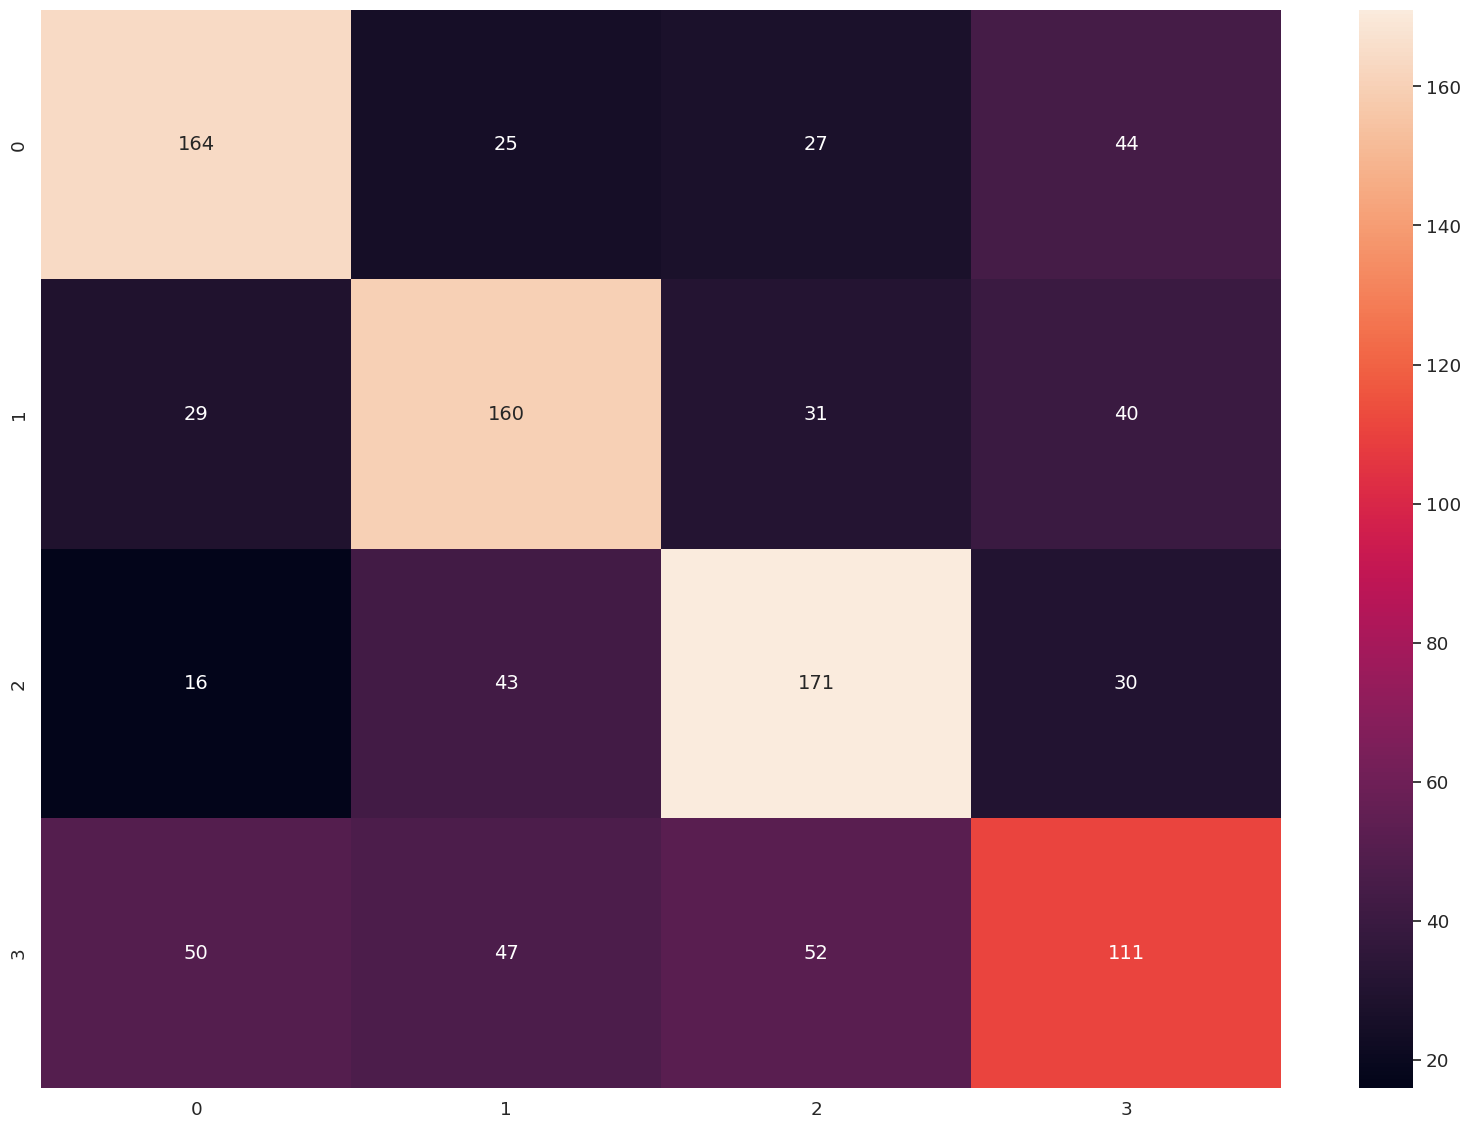

In [ ]:
df_cm = pd.DataFrame(cm, range(4), range(4))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         pos     0.6332    0.6308    0.6320       260
         bly     0.5818    0.6154    0.5981       260
         hig     0.6085    0.6577    0.6322       260
         neg     0.4933    0.4269    0.4577       260

    accuracy                         0.5827      1040
   macro avg     0.5792    0.5827    0.5800      1040
weighted avg     0.5792    0.5827    0.5800      1040

